# Identification of predictive biomarkers for IO in NSCLC second line therapy

* In this notebook we are going to use the data from the POPLAR (Ph 2 clinical trial) to identify potential predictive biomarker of Atezolizumab compared to Docetaxel for the NSCLC indication in patients with failed 1L platinum based chemotherapy. 
* We will evaluate the biomarker in a twin Phase 3 clinical trial (OAK). 
* **Parameters**: same as for publication 

**What to expect from this demo**
* Familiarize with the PBMF API throught he whole proces for identifying predictive biomarkers. 
* You will be able to run the PBMF using your own data. 

## Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

%config InlineBackend.figure_format = 'svg'

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from samecode.plot.pyplot import subplots
from samecode.survival.plot import KMPlot

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [5]:
# KMPlot.plot?
linewidth=2

t1 = 'IO'
ct = 'SOC'
KMARGS = dict(
    x_legend = 0.5, y_legend = 0.95, legend_font_size=8,
    comparisons=[
        ['{}_B+'.format(t1), '{}_B+'.format(ct), 'B+: '.format()],
        ['{}_B-'.format(t1), '{}_B-'.format(ct), 'B-: '.format()],
        ['{}_B+'.format(t1), '{}_B-'.format(t1), 'IO: '.format()],
        ['{}_B+'.format(ct), '{}_B-'.format(ct), 'SOC: '.format()]
    ],
    x_hr_legend = 0.0, y_hr_legend = 0.2, hr_font_size=8, 
    hr_color='black',
    linewidth=linewidth,
    template_color = '#8A8F91',
    linestyle=['--', '-', '--', '-'],
    show_censor=True
)

## System version
Let's check the version of the system and tensorflow we are using for running the demo.

In [6]:
import tensorflow as tf
tf.__version__

'2.6.0'

In [7]:
import platform
print('''System: 
    Architecture: {}
    Version: {}
    Processor: {}'''.format(
platform.architecture()[0],
platform.version(),
platform.processor(),
))

System: 
    Architecture: 64bit
    Version: #1 SMP Tue Mar 25 21:34:29 UTC 2025
    Processor: x86_64


## Dataset
The dataset was obtained from XXXX et., al and processed for making it machine learning ready. We will perform a basic data transformation here.

In [8]:
dataset = pd.read_csv('../data/ML-ready-oak-poplar.tsv', sep='\t')

In [9]:
dataset['HIST'] = dataset['HIST'].replace(['NON-SQUAMOUS', 'SQUAMOUS'], [0, 1])
dataset['SEX'] = dataset['SEX'].replace(['F', 'M'], [0, 1])
dataset['TOBHX'] = dataset['TOBHX'].replace(['NEVER', 'PREVIOUS', 'CURRENT'], [0, 0.5, 1])

In [10]:
dataset = dataset[dataset.QC_Status == 'pass'].reset_index()

In [11]:
dataset['treat'] = dataset.Treatment.replace(['SOC', 'IO'], [0, 1])
dataset['OS_EVENT'] = 1 - dataset['OS.CNSR']
dataset['PFS_EVENT'] = 1 - dataset['PFS.CNSR']

In [12]:
mutations = list(dataset.columns[dataset.columns.str.match('mutations_')])

In [13]:
data_train, data_test = dataset[dataset.Study_x == 'POPLAR'],  dataset[dataset.Study_x == 'OAK']
data_train = data_train.reset_index(drop=True).copy()
data_test = data_test.reset_index(drop=True).copy()

data_train.shape, data_test.shape

((206, 843), (638, 843))

In [14]:
top_genes = list(data_train[mutations].sum().sort_values(ascending=False)[:20].keys())

## Feature set
For training the PBMF we are using a set of clinical and genomic features (top 20 most mutated genes). Description about the feature names can be found in XXXX et., al.

In [15]:
time = 'OS'
event = 'OS_EVENT'
treatment = 'treat'

features = [  
    # Molecular derived features
    'blSLD',
    'btmb',
    'MSAF', 
    
    # Tumor characteristics
    'METSITES',
    'HIST',
    'ECOGGR',
    
    # Patient characteristics
    'SEX',
    'BAGE',
    'TOBHX',
]

top_genes = list(data_train[mutations].sum().sort_values(ascending=False)[:20].keys())

## PBMF Training

In [16]:
from PBMF.attention.model_zoo.SimpleModel import Net
from PBMF.attention.model_zoo.Ensemble import EnsemblePBMF

In [17]:
params = dict(
    ignore_patients_frac=0.1, # During training, ignore this % of patients before computing the loss
    layers=[64], # a neural network of 64 units
    epochs=500, 
    minp=0.75, # force the model to get this minimum population (condition on w2, if w2=0 this variable is not relevant)
    w1=1.0, # w1 parameter in the loss
    w2=0.0, # w2 parameter in the loss
    seed=0,
    learning_rate=0.01,
    shuffle=True,
    shuffle_features=False,
    l1=0.0, # L1 normalization
)

In [18]:
pbmf = EnsemblePBMF(
    time=time, 
    event=event,
    treatment=treatment,
    stratify=treatment,
    features = features + top_genes,
    discard_n_features=1, # discard 1 feature on each PBMF model
    architecture=Net, # Architecrture to use, we are using a simple NN.
    **params
)

pbmf.fit(
    data_train, 
    num_models=100, # number of PBMF models used in the ensemble
    n_jobs=100,
    test_size=0.2, # Discard this fraction (randomly) of patients when fiting a PBMF model
    outdir='./results/emsemble_simple_model/',
    save_freq=100,
)

## PBMF Testing
Here we are evaluating the ensemble model over the independent validation datset (OAK)

In [19]:
pbmf = EnsemblePBMF()
pbmf.load(
    architecture=Net,
    outdir='./results/emsemble_simple_model/',
    num_models=100,
)

In [20]:
%%capture
data_train['consensus_risk'] = pbmf.predict(data_train, epoch=500, return_all_models_predictions=True)
data_test['consensus_risk'] = pbmf.predict(data_test, epoch=500, return_all_models_predictions=True)

In [21]:
data_train['bin_risk'] = (data_train['consensus_risk'] > 0.5).replace([False, True], ['B-', 'B+'])
data_test['bin_risk'] = (data_test['consensus_risk'] > 0.5).replace([False, True], ['B-', 'B+'])

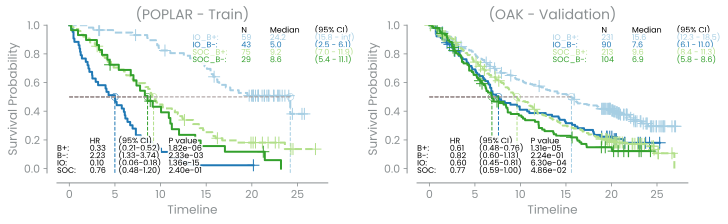

In [22]:
f, axs = subplots(cols=2, rows=1, w=10, h=3, return_f=True)

KMPlot(data_train, time=time, event=event, label=['Treatment', 'bin_risk']).plot(
    ax=axs[0],
    title='(POPLAR - Train)',
    **KMARGS
);


KMPlot(data_test, time=time, event=event, label=['Treatment', 'bin_risk']).plot(
    ax=axs[1],
    title='(OAK - Validation)',
    **KMARGS
);

sns.despine(offset=10);

# PBMF Pruning
Now, let's remove all the not so useful models from the PBMF ensemble.

In [23]:
from PBMF.attention.model_zoo.Pruning import select_models, compute_consensus_parallel, compute_correlations_parallel

In [47]:
num_models = 100
select_percentile = 95

In [48]:
%%capture

res = compute_consensus_parallel(data_train,['risk_seed{}'.format(i) for i in range(num_models)], thr = 0.5, n_jobs = 1)
res_corr = compute_correlations_parallel(data_train, ['risk_seed{}'.format(i) for i in range(num_models)], res, n_jobs = 1)
selected_models = select_models(res_corr, drop_negatives = True, select_percentile = select_percentile)

pbmf_min = EnsemblePBMF()
pbmf_min.load(
    architecture=Net,
    outdir='./results/emsemble_simple_model/',
    num_models = selected_models
)

data_train['pruning_consensus_risk'] = pbmf_min.predict(data_train, epoch=500)
data_test['pruning_consensus_risk'] = pbmf_min.predict(data_test, epoch=500)

In [49]:
data_train['pruning_bin_risk'] = (data_train['pruning_consensus_risk'] > 0.5).replace([False, True], ['B-', 'B+'])
data_test['pruning_bin_risk'] = (data_test['pruning_consensus_risk'] > 0.5).replace([False, True], ['B-', 'B+'])

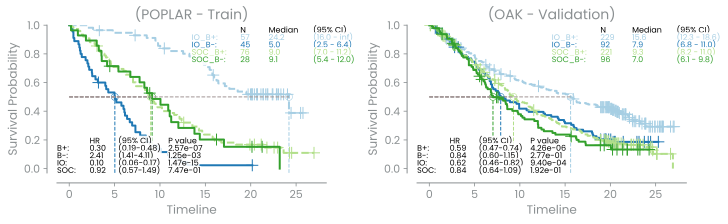

In [50]:
f, axs = subplots(cols=2, rows=1, w=10, h=3, return_f=True)

KMPlot(data_train, time=time, event=event, label=['Treatment', 'pruning_bin_risk']).plot(
    ax=axs[0],
    title='(POPLAR - Train)',
    **KMARGS
);


KMPlot(data_test, time=time, event=event, label=['Treatment', 'pruning_bin_risk']).plot(
    ax=axs[1],
    title='(OAK - Validation)',
    **KMARGS
);

sns.despine(offset=10);

# PBMF Distilation
Pruning worked quite well!!, now, we need interpretability!. In this section we will distil the ensemble PBMF to a simple tree using the labels from the pruning (biomarker postive and negative). 

The idea is simple, from the PBMF ensemble we classify each patient to the biomarker positive (B+) or negative (B-). Now, we use a tree classifier to predict this biomarker using all our input features. 

In [51]:
from samecode.survival import extract_kmstats
from samecode.survival.plot import forestplot

## Pseudo labeling (optional)
In this step we want to determine if there are patients with low quality predictions to be removed before the distilation into a simple tree. 

In [52]:
pseudo_labeling_data = data_train[[time, event, treatment, 'pruning_consensus_risk', 'pruning_bin_risk']]

In [53]:
lrs = []
for thr in [0.0, 0.1, 0.2, 0.3, 0.4]:
    dt = pseudo_labeling_data[
        ~((pseudo_labeling_data['pruning_consensus_risk'] > 0.5-thr) & 
          (pseudo_labeling_data['pruning_consensus_risk'] < 0.5+thr))
    ]
    
    for biomarker in ['B+', 'B-']:
        lr = extract_kmstats(dt[dt.pruning_bin_risk == biomarker], [treatment], time, event)
        lr['variable'] = biomarker
        lr['thr'] = thr
        
        lrs.append(lr)

lrs = pd.concat(lrs)

In [54]:
lrs['info'] = lrs.variable + " Atezo:  " + lrs.n1.astype(str) + " Doce: " + lrs.n0.astype(str)
lrs['dataset'] = 'POPLAR'

In [55]:
# axs = subplots(cols=1, rows=1, w=3, h=2.5)
# props = dict(
#     marker='o',
#     marker_s=90,
#     linewidth=2.0,
#     xlabel='Hazard Ratio',
#     table_fontsize=12,
#     xlim=[0., 5],
    
#     population='variable',
#     population_colors=['black', 'gray'],
#     population_name='info',
#     group='thr',
#     groups=[0.0, 0.1, 0.2, 0.3, 0.4],
#     variable='dataset',
    
#     offset=0.5, 
#     ylabel_offset=-0.1, 
#     xlabel_offset=-0.5,
#     ylabel_align='left',
#     label_fontsize=10
# )

# forestplot(lrs, ax=axs[0], **props)

In [56]:
lrs

,variable,hr,hr_lo,hr_hi,pval,n1,n0,thr,info,dataset
0,B+,0.301475,0.191051,0.475720,2.574805e-07,57,76,0.0,B+ Atezo: 57 Doce: 76,POPLAR
0,B-,2.408875,1.412106,4.109239,1.253804e-03,45,28,0.0,B- Atezo: 45 Doce: 28,POPLAR
0,B+,0.301472,0.190578,0.476893,2.983876e-07,57,74,0.1,B+ Atezo: 57 Doce: 74,POPLAR
0,B-,2.253242,1.309690,3.876567,3.340540e-03,42,26,0.1,B- Atezo: 42 Doce: 26,POPLAR
0,B+,0.286506,0.179151,0.458192,1.809806e-07,56,69,0.2,B+ Atezo: 56 Doce: 69,POPLAR
0,B-,2.177638,1.229856,3.855822,7.591566e-03,40,22,0.2,B- Atezo: 40 Doce: 22,POPLAR
0,B+,0.280846,0.173438,0.454771,2.415284e-07,53,64,0.3,B+ Atezo: 53 Doce: 64,POPLAR
0,B-,1.927670,1.040947,3.569741,3.683273e-02,35,18,0.3,B- Atezo: 35 Doce: 18,POPLAR
0,B+,0.250486,0.147658,0.424922,2.838088e-07,47,53,0.4,B+ Atezo: 47 Doce: 53,POPLAR
0,B-,1.860371,0.970751,3.565261,6.141219e-02,33,16,0.4,B- Atezo: 33 Doce: 16,POPLAR


We select then the thr = 0 as it give us the best predictive biomarker and the highest prevalence (number of patients) compared to the other thresholds.

## Decision tree distilation
Now let's train the tree classifier!

In [57]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

In [58]:
thr = 0.0

data_train_tree = data_train[
    ~((data_train['pruning_consensus_risk'] > 0.5-thr) & 
    (data_train['pruning_consensus_risk'] < 0.5+thr))
].copy().reset_index(drop=True)

In [59]:
tree_features = features + top_genes

In [60]:
clf = DecisionTreeClassifier(random_state=0, max_depth=3)

In [61]:
clf.fit(
    data_train_tree[tree_features].fillna(0),
    data_train_tree.pruning_bin_risk
)

DecisionTreeClassifier(max_depth=3, random_state=0)

In [62]:
data_train['tree_bin_risk'] = clf.predict(data_train[tree_features].fillna(0))
data_test['tree_bin_risk'] = clf.predict(data_test[tree_features].fillna(0))

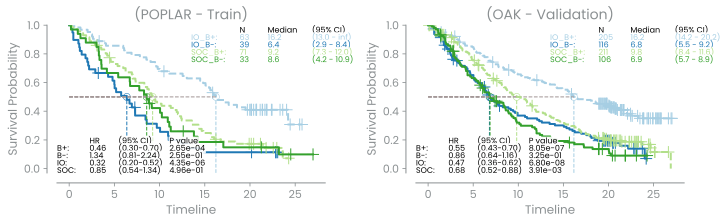

In [63]:
f, axs = subplots(cols=2, rows=1, w=10, h=3, return_f=True)

KMPlot(data_train, time=time, event=event, label=['Treatment', 'tree_bin_risk']).plot(
    ax=axs[0],
    title='(POPLAR - Train)',
    **KMARGS
);


KMPlot(data_test, time=time, event=event, label=['Treatment', 'tree_bin_risk']).plot(
    ax=axs[1],
    title='(OAK - Validation)',
    **KMARGS
);

sns.despine(offset=10);

### Biomarkers rule

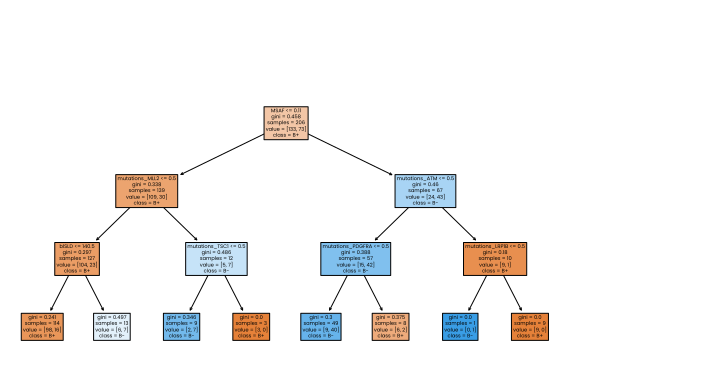

In [64]:
axs = subplots(cols=1, rows=1, w=10, h=5)
text_tree = plot_tree(clf, feature_names=tree_features, class_names=['B+', 'B-'], filled=True, ax=axs[0])

# Final Remarks

* We were able to find a predictive biomarker for IO vs chemotherapy in the POPLAR trial that was consistent in the OAK trial. 
* The PBMF with pruning + distilation allow us to define a set of potential biomarker combinations explained by the simple tree. 